In [83]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import cross_validation, linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

actor_full = pd.read_pickle('joint_df.pickle')
actor_full.head()

,movie,release,actor,rank,studio,adjusted_gross,unadjusted_gross,actor_id,Canadian male voice actors,21st-century Australian actresses,...,Outstanding Performance by a Female Actor in a Miniseries or Television Movie Screen Actors Guild Award winners,Articles with unsourced statements from February 2016,Articles with unsourced statements from April 2016,male_txt,age_on_release,release_day,release_date,production_budget,domestic_gross,worldwide_gross
0,(500) Days of Summer,2009,Chloe Moretz,11,FoxS,37749800,32391374,chloemoretz,False,False,...,False,False,False,0,4540 days,2009-07-17,2009-07-17,7500000,32391374,59101642
1,(500) Days of Summer,2009,Clark Gregg,7,FoxS,37749800,32391374,clarkgregg,False,False,...,False,False,False,1,17273 days,2009-07-17,2009-07-17,7500000,32391374,59101642
2,(500) Days of Summer,2009,Minka Kelly,-,FoxS,37749800,32391374,minkakelly,False,False,...,False,False,False,0,10615 days,2009-07-17,2009-07-17,7500000,32391374,59101642
3,(500) Days of Summer,2009,Zooey Deschanel,10,FoxS,37749800,32391374,zooeydeschanel,False,False,...,False,False,False,0,10774 days,2009-07-17,2009-07-17,7500000,32391374,59101642
4,10 Cloverfield Lane,2016,Mary Elizabeth Winstead,4,Par.,68379000,68378983,maryelizabethwinstead,False,False,...,False,False,False,0,11426 days,2016-03-11,2016-03-11,5000000,69793284,101493284


In [84]:
actor_data = actor_full.drop(['rank','unadjusted_gross','actor_id'], axis=1)

# drop the NaN's
pre_drop_nans = len(actor_data)
actor_data.dropna(inplace=True)
print'Dropped %i rows with NaNs. There are %i left.' % (pre_drop_nans-len(actor_data), len(actor_data))
print '\n* * *\n'

# will this inverse feature be useful? ***NO***
# it does not affect the model with all the wikipedia category boolean features
# it does not affect the simple model that uses only actor_data[['bday','age_on_release','male_txt']]
# it does not affect the polynomial model with 
#     poly_features = ['bday','age_on_release','release','male_txt','female_txt']
# actor_data['female_txt'] = 1 - actor_data.male_txt

# convert times to yearly
secs_per_year = 31622400.0
actor_data.age_on_release = actor_data.age_on_release.dt.total_seconds()/secs_per_year

for col in ['bday']:
    actor_data[col] = actor_data[col].dt.year

# calculate crude ROI
actor_data['roi'] = actor_data.domestic_gross / actor_data.production_budget
    
# filter out crazy erroneous stuff
# by eye looking at pre-filtered scatterplots
pre_filter_len = len(actor_data)
actor_data = actor_data[(actor_data.age_on_release < 100) 
    & (actor_data.bday > 1920) & (actor_data.release < 2015)]
print'Filtered out %i rows with impossible/extreme values. There are %i rows left.' % (
    pre_filter_len-len(actor_data), len(actor_data))
print '\n* * *\n\n'
    
readable_cols = ['actor','bday','movie','release','adjusted_gross',
                 'production_budget','age_on_release','male_txt','roi']
actor_data[readable_cols].head()

Dropped 0 rows with NaNs. There are 9342 left.

* * *

Filtered out 399 rows with impossible/extreme values. There are 8943 rows left.

* * *




,actor,bday,movie,release,adjusted_gross,production_budget,age_on_release,male_txt,roi
0,Chloe Moretz,1997,(500) Days of Summer,2009,37749800,7500000,12.404372,0,4.318850
1,Clark Gregg,1962,(500) Days of Summer,2009,37749800,7500000,47.193989,1,4.318850
2,Minka Kelly,1980,(500) Days of Summer,2009,37749800,7500000,29.002732,0,4.318850
3,Zooey Deschanel,1980,(500) Days of Summer,2009,37749800,7500000,29.437158,0,4.318850
5,Glenn Close,1947,102 Dalmatians,2000,107144200,85000000,53.571038,0,0.787548


In [85]:
# set movies_count for each actor
actor_data.set_index('actor', inplace=True)
actor_data['movies_count'] = actor_data.reset_index().groupby('actor').movie.apply(pd.Series.count)

actor_data.reset_index(inplace=True)
actor_data[readable_cols].head(10)

,actor,bday,movie,release,adjusted_gross,production_budget,age_on_release,male_txt,roi
0,Chloe Moretz,1997,(500) Days of Summer,2009,37749800,7500000,12.404372,0,4.318850
1,Clark Gregg,1962,(500) Days of Summer,2009,37749800,7500000,47.193989,1,4.318850
2,Minka Kelly,1980,(500) Days of Summer,2009,37749800,7500000,29.002732,0,4.318850
3,Zooey Deschanel,1980,(500) Days of Summer,2009,37749800,7500000,29.437158,0,4.318850
4,Glenn Close,1947,102 Dalmatians,2000,107144200,85000000,53.571038,0,0.787548
5,Ioan Gruffudd,1973,102 Dalmatians,2000,107144200,85000000,27.073770,1,0.787548
6,Giovanni Ribisi,1974,10th & Wolf,2006,72700,8000000,31.603825,1,0.006838
7,James Marsden,1973,10th & Wolf,2006,72700,8000000,32.846995,1,0.006838
8,Piper Perabo,1976,10th & Wolf,2006,72700,8000000,29.734973,0,0.006838
9,Val Kilmer,1959,10th & Wolf,2006,72700,8000000,46.535519,1,0.006838


20


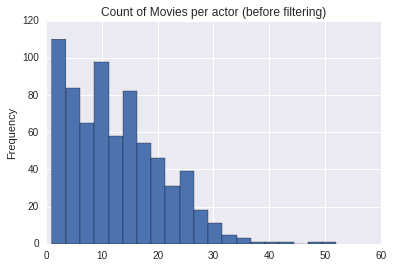

In [86]:
print actor_data[actor_data.actor == 'Zooey Deschanel'].movies_count.iloc[0]

actor_data.reset_index().groupby('actor').movies_count.first().plot.hist(
    title='Count of Movies per actor (before filtering)', bins=20);

In [87]:
# only include actors with over N movies (less than would not give enough data to be useful)
movie_count_thresh = 10

pre_filter_len = len(actor_data)
actor_data = actor_data[actor_data.movies_count > movie_count_thresh]
print 'removed %i actors, %i left' % (pre_filter_len-len(actor_data), len(actor_data))

removed 1751 actors, 7192 left


In [88]:
# drop the text columns (except for actor)
actor_data.drop(['movie','studio'], axis=1, inplace=True)

# keep only the int-formatted release year, 'release'
actor_data.drop(['release_day','release_date'], axis=1, inplace=True)

# # convert datetime/timedelta to numeric
# for col in actor_data.select_dtypes(exclude=['bool']).columns:
#     print '(before)', col, '\t\t', actor_data[col].dtype
#     actor_data[col] = pd.to_numeric(actor_data[col])
#     print '(after )', col, '\t\t', actor_data[col].dtype, '\n'

actor_data.head()

,actor,release,adjusted_gross,Canadian male voice actors,21st-century Australian actresses,Canadian male television actors,English people of Irish descent,Commanders of the Order of the British Empire,Wikipedia protected pages without expiry,American atheists,...,Outstanding Performance by a Female Actor in a Miniseries or Television Movie Screen Actors Guild Award winners,Articles with unsourced statements from February 2016,Articles with unsourced statements from April 2016,male_txt,age_on_release,production_budget,domestic_gross,worldwide_gross,roi,movies_count
0,Chloe Moretz,2009,37749800,False,False,False,False,False,False,False,...,False,False,False,0,12.404372,7500000,32391374,59101642,4.318850,15
1,Clark Gregg,2009,37749800,False,False,False,False,False,False,False,...,False,False,False,1,47.193989,7500000,32391374,59101642,4.318850,17
3,Zooey Deschanel,2009,37749800,False,False,False,False,False,False,False,...,False,False,False,0,29.437158,7500000,32391374,59101642,4.318850,20
4,Glenn Close,2000,107144200,False,False,False,False,False,False,False,...,True,False,False,0,53.571038,85000000,66941559,66941559,0.787548,12
6,Giovanni Ribisi,2006,72700,False,False,False,False,False,False,False,...,False,False,False,1,31.603825,8000000,54702,143782,0.006838,23


In [89]:
# actor_data.to_pickle('actor_data_cleaned.pickle')

# Done cleaning data. Start modeling.

In [90]:
dependent_var = 'roi'

In [91]:
# The convenience fn train_test_split() randomly splits X and y into train and test.
# For results to be reproducible, set the random seed

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data.drop(['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data[dependent_var],
    test_size=0.3, 
    random_state=0)

print 'Attempting to predict y="%s"\n\n' % y_train.name

non_bool_columns = [col for col in X_train.columns if X_train[col].dtype != 'bool']

# look at all the non-bool features
print 'non-bool features in X:\n'
for col in non_bool_columns:
    print col, '\t', X_train[col].dtype

print '\n\nthey look like:\n'
X_train[non_bool_columns].head()

Attempting to predict y="roi"


non-bool features in X:

release 	int64
bday 	int64
male_txt 	float64
age_on_release 	float64
movies_count 	int64


they look like:



,release,bday,male_txt,age_on_release,movies_count
4812,2002,1990,0,11.945355,16
1070,2000,1972,0,28.081967,22
5271,2008,1940,1,68.243169,17
8095,2008,1974,0,34.453552,18
5491,1993,1962,1,30.918033,21


In [92]:
lasso_model = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=3000)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=3000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [93]:
def make_coef_df(model, X_train, y_train, significance_thresh=0):
    print 'alpha (aka lambda) for model: %f' % model.alpha_
    print 'intercept for model: %f' % model.intercept_
    print 'R-squared (unadjusted??) of model on training set:', model.score(X_train, y_train)

    significant_columns = np.where(abs(model.coef_) > significance_thresh)[0]
    
    print '\ngot %i significant columns (abs is > %f) out of %i' % (
        len(significant_columns), significance_thresh, len(model.coef_))

    coef_df = pd.DataFrame(
        [(model.coef_[idx], X_train.columns[idx]) for idx in significant_columns], 
        index=significant_columns, columns=['coef','col_name'])

    # sort coefficients by absolute value
    coef_df = coef_df.loc[coef_df.coef.abs().sort_values(ascending=False).index]
    return coef_df

In [94]:
# top 20
coef_df = make_coef_df(lasso_model, X_train, y_train)
coef_df.head(20)

alpha (aka lambda) for model: 0.003623
intercept for model: 168.001134
R-squared (unadjusted??) of model on training set: 0.0337271527636

got 1 significant columns (abs is > 0.000000) out of 344


,coef,col_name
0,-0.082914,release


In [95]:
for interest in ['People from Manhattan'] + non_bool_columns:
    idx = X_train.columns.get_loc(interest)
    print lasso_model.coef_[idx], interest

0.0 People from Manhattan
-0.0829139146867 release
0.0 bday
-0.0 male_txt
-0.0 age_on_release
0.0 movies_count


In [96]:
# my columns of interest, besides those bools
coef_df[coef_df.col_name.isin(non_bool_columns)]

,coef,col_name
0,-0.082914,release


In [97]:
# most positive betas
coef_df.sort_values('coef', ascending=False).head(10)

,coef,col_name
0,-0.082914,release


In [98]:
# most negative betas
coef_df.sort_values('coef').head(10)

,coef,col_name
0,-0.082914,release


# Try a much simpler model

In [99]:
X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data[['bday','age_on_release','male_txt']], 
    actor_data[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

alpha (aka lambda) for model: 0.000113
intercept for model: 221.189843
R-squared (unadjusted??) of model on training set: 0.0380032485081

got 3 significant columns (abs is > 0.000000) out of 3


,coef,col_name
1,-0.121764,age_on_release
0,-0.109223,bday
2,0.047769,male_txt


# Exploratory plots

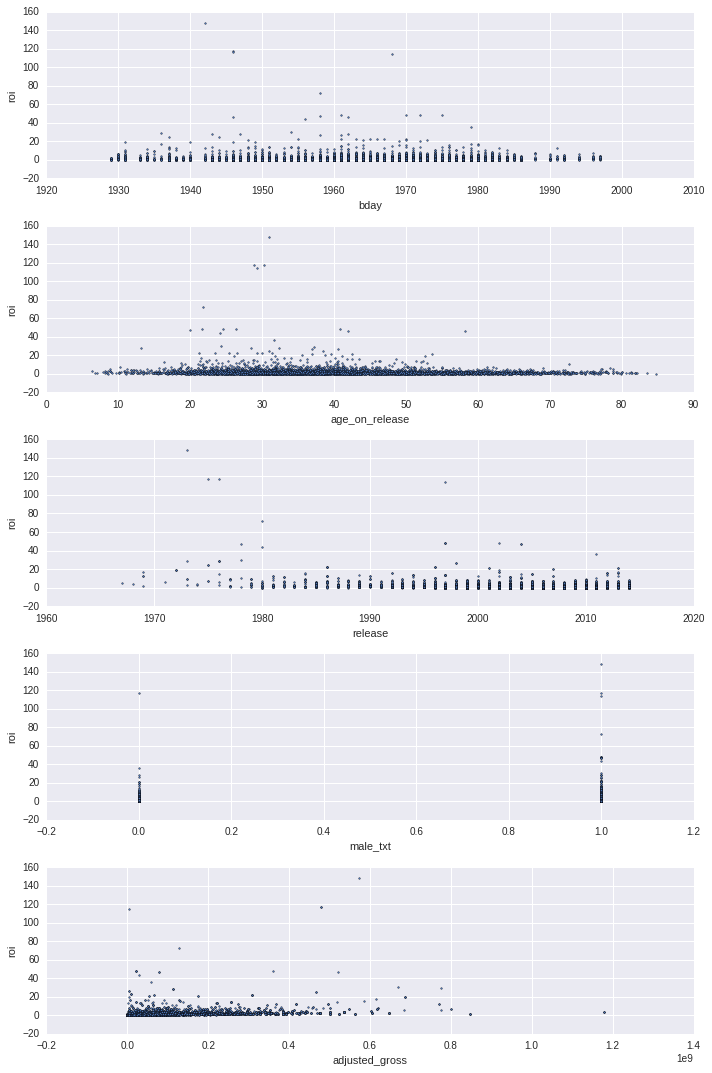

In [100]:
cols_to_plot = ['bday','age_on_release','release','male_txt','adjusted_gross']

plt.figure(figsize=(10,15))

for idx, col in enumerate(cols_to_plot):
    ax = plt.subplot(len(cols_to_plot),1,idx+1)
    plt.xlabel(col)
    actor_data.plot.scatter(col, dependent_var, ax=ax, s=3)
    
plt.tight_layout()

# Warning: these plots are by movie-and-actor rows. A given movie and actor will have multiple rows. They should probably be grouped first...

Count: 5033 males, 2159 females
Male   mean adj gross: 1
Female mean adj gross: 1
men gross 0 more than women (diff of means)


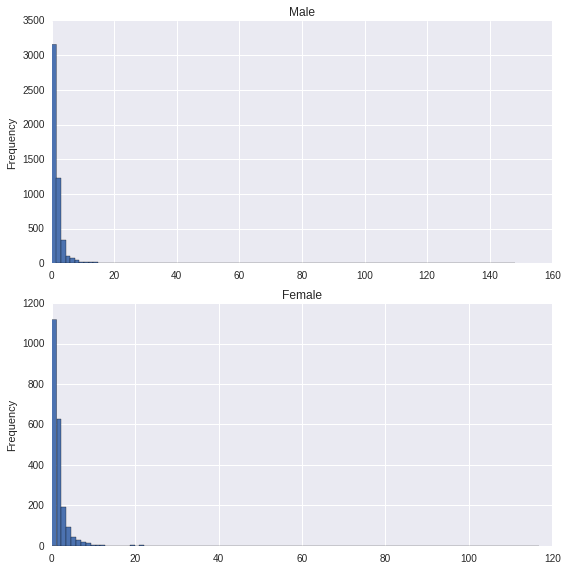

In [101]:
no_bins = 100
plt.figure(figsize=(8,8))

males_adj_gross = actor_data[actor_data.male_txt==1][dependent_var]
females_adj_gross = actor_data[actor_data.male_txt==0][dependent_var]

print 'Count: %i males, %i females' % (len(males_adj_gross), len(females_adj_gross))
print 'Male   mean adj gross: %i\nFemale mean adj gross: %i' % (males_adj_gross.mean(), females_adj_gross.mean())
print 'men gross %i more than women (diff of means)' % (males_adj_gross.mean() - females_adj_gross.mean())
ax = plt.subplot(2,1,1)
males_adj_gross.plot.hist(bins=no_bins, title='Male')

ax = plt.subplot(2,1,2)
females_adj_gross.plot.hist(bins=no_bins, ax=ax, title='Female')

plt.tight_layout()

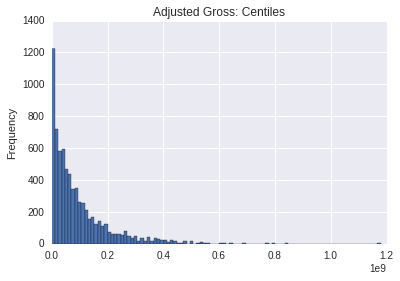

In [102]:
actor_data.adjusted_gross.plot.hist(bins=100)
plt.title('Adjusted Gross: Centiles');

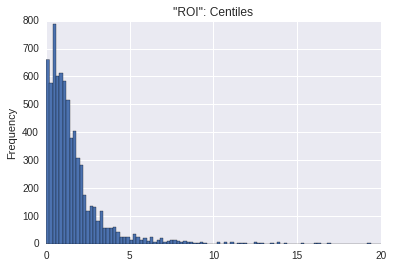

In [103]:
actor_data.roi.plot.hist(bins=100, range=(0,20))
plt.title('"ROI": Centiles');

min:6
max:84
mean:39


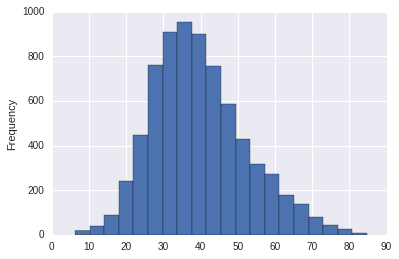

In [104]:
print 'min:%i\nmax:%i\nmean:%i' % (
    actor_data.age_on_release.min(), actor_data.age_on_release.max(), actor_data.age_on_release.mean())

actor_data.age_on_release.plot.hist(bins=20);

women median age on movie release 33
men median age on movie release  40
* * * 
women mean age on movie release 34
men mean age on movie release  41



Distribution of actor ages on movie release date by gender


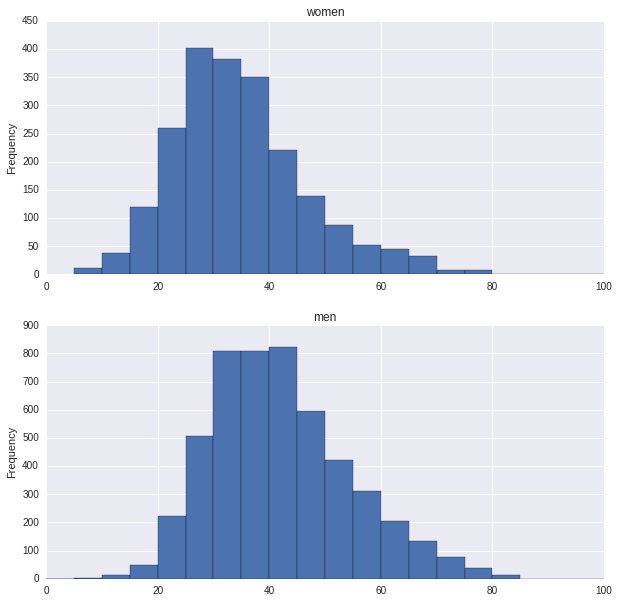

In [105]:
women = actor_data[actor_data.male_txt == 0].age_on_release
men = actor_data[actor_data.male_txt == 1].age_on_release

print 'women median age on movie release %i\nmen median age on movie release  %i' % (women.median(), men.median())
print '* '*3
print 'women mean age on movie release %i\nmen mean age on movie release  %i' % (women.mean(), men.mean())
print '\n\n'
print 'Distribution of actor ages on movie release date by gender'

plt.figure(figsize=(10,10))
ax = plt.subplot(2,1,1)
women.plot.hist(bins=20, ax=ax, title='women', range=[0,100])
ax = plt.subplot(2,1,2)
men.plot.hist(bins=20, ax=ax, title='men', range=[0,100]);

**Try polynomial features on age/date**

In [106]:
def plot_age_curve(actor_names, figsize=(10,10), y='production_budget'):
    """df is a dataframe with actor data, indexed by actor name"""
    plt.figure(figsize=figsize)
    
    if isinstance(actor_names, str):
        actor_names = [actor_names]
    
    actor_df = actor_data.set_index('actor')
    
    for idx, actor_name in enumerate(actor_names):
        ax = plt.subplot(len(actor_names), 1, idx+1)
        fig = actor_df.loc[actor_name].groupby('age_on_release', as_index=False).sum().plot(
            x='age_on_release', y=y, title=actor_name, ax=ax)
    
    return ax

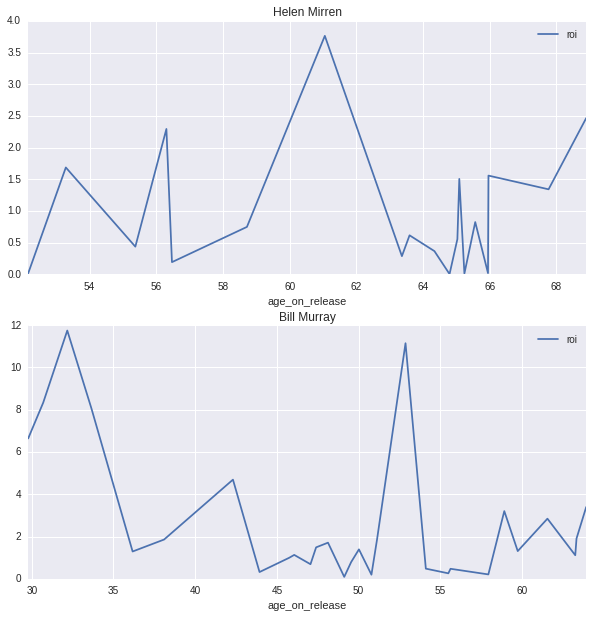

In [153]:
selected_mf_actors = ['Helen Mirren','Bill Murray']
plot_age_curve(selected_mf_actors, y='roi');

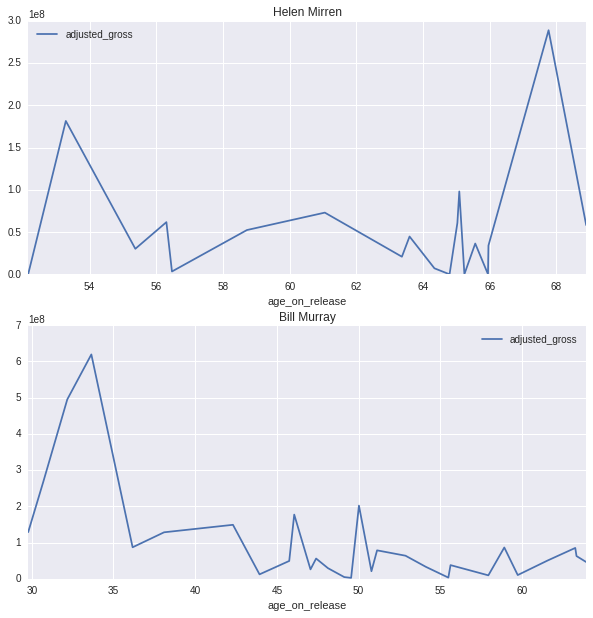

In [154]:
plot_age_curve(selected_mf_actors, y='adjusted_gross');

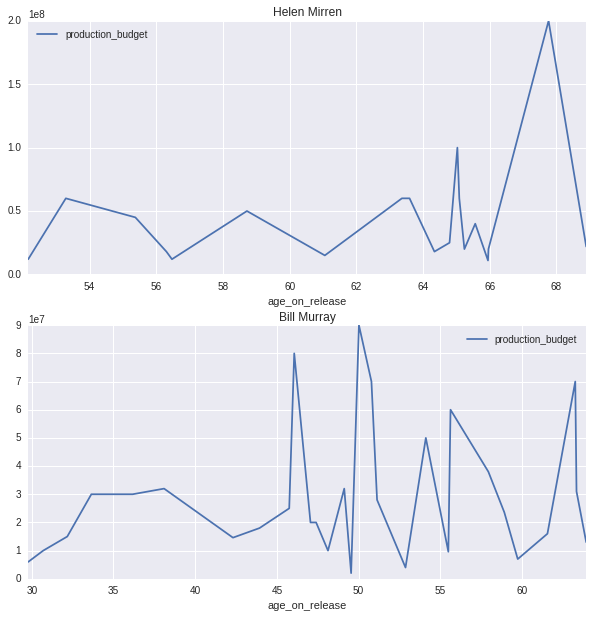

In [155]:
plot_age_curve(selected_mf_actors, y='production_budget');

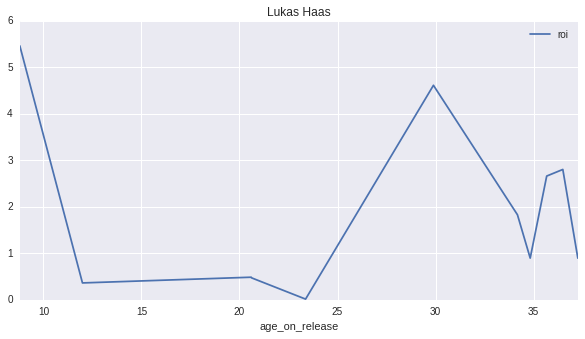

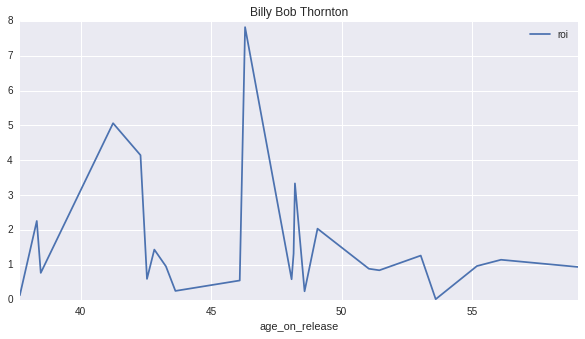

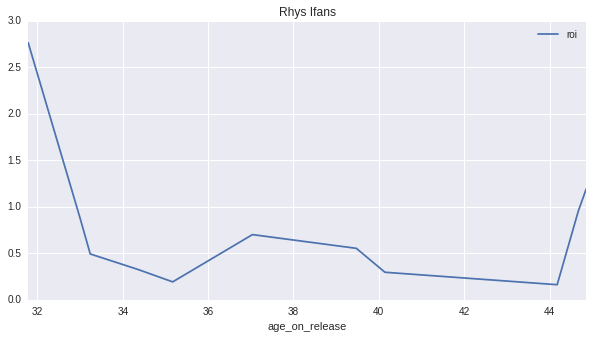

In [109]:
# plot some random age curves
for name in np.random.choice(actor_data.actor.unique(), size=3, replace=False):
    plot_age_curve(name, figsize=(10,5), y='roi')

# Polynomial model of selected non-category features

In [110]:
poly_features = ['bday','age_on_release','release','male_txt']

X_train3, X_test3, y_train3, y_test3 = cross_validation.train_test_split(
    actor_data[poly_features], 
    actor_data.production_budget, 
    test_size=0.3, 
    random_state=0)

poly_lasso = make_pipeline(PolynomialFeatures(), 
    linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=8000))

poly_lasso.fit(X_train3, y_train3)

lasso3 = poly_lasso.get_params()['lassocv']
poly_feat3 = poly_lasso.get_params()['polynomialfeatures']

print lasso3.coef_
print poly_feat3.powers_

[  0.00000000e+00  -0.00000000e+00   0.00000000e+00   1.37668559e+06
   0.00000000e+00  -0.00000000e+00   9.69854780e+01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.98377494e+05
   9.46791631e-03   0.00000000e+00   0.00000000e+00]
[[0 0 0 0]
 [1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [2 0 0 0]
 [1 1 0 0]
 [1 0 1 0]
 [1 0 0 1]
 [0 2 0 0]
 [0 1 1 0]
 [0 1 0 1]
 [0 0 2 0]
 [0 0 1 1]
 [0 0 0 2]]


In [111]:
def get_poly_labels(labels, poly_obj):
    final_labels = []
    separator = '_x_'
    for power_list in poly_obj.powers_:
        s = ''
        for label, power in zip(labels, power_list):
            if power != 0:
                s += "%s_p%i%s" % (label, power, separator)
        if s == '':
            final_labels.append('1')
        else:
            final_labels.append(s[:-len(separator)])
    
    return final_labels
        
poly_labels = get_poly_labels(poly_features, poly_feat3)
pd.DataFrame(zip(poly_labels, list(lasso3.coef_)), columns=['feature','coef']).sort_values('coef', ascending=False)

,feature,coef
3,release_p1,1376685.591105
11,age_on_release_p1_x_male_txt_p1,198377.493923
6,bday_p1_x_age_on_release_p1,96.985478
12,release_p2,0.009468
0,1,0.000000
1,bday_p1,-0.000000
2,age_on_release_p1,0.000000
4,male_txt_p1,0.000000
5,bday_p2,-0.000000
7,bday_p1_x_release_p1,0.000000


In [112]:
print 'R-squared score:'
poly_lasso.score(X_train3, y_train3)

R-squared score:


0.075286216020713059

From the coefficients above, it looks like these combined features are useful:

```
age_on_release * male_txt
age_on_release^2
bday * male_txt
```

So I'll manually generate them:

In [113]:
actor_data_eng = actor_data.copy()

actor_data_eng['age_on_release_x_male_txt'] = actor_data_eng.age_on_release * actor_data_eng.male_txt
actor_data_eng['age_on_release_p2'] = actor_data_eng.age_on_release**2
actor_data_eng['bday_x_male_txt'] = actor_data_eng.bday * actor_data_eng.male_txt

X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data_eng.drop(['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data_eng[dependent_var],
    test_size=0.3, 
    random_state=0)

print len(X_train), len(X_test)
print '\n\n Features:\n'
print [col for col in X_train.columns if X_train[col].dtype != 'bool']
print '\nBools\n'
print [col for col in X_train.columns if X_train[col].dtype == 'bool']

y_train.head()

5034 2158


 Features:

['release', 'bday', 'male_txt', 'age_on_release', 'movies_count', 'age_on_release_x_male_txt', 'age_on_release_p2', 'bday_x_male_txt']

Bools

['Canadian male voice actors', '21st-century Australian actresses', 'Canadian male television actors', 'English people of Irish descent', 'Commanders of the Order of the British Empire', 'Wikipedia protected pages without expiry', 'American atheists', '1992 births', 'English male television actors', 'Best Supporting Actress Academy Award winners', 'Articles with unsourced statements from January 2016', 'Articles with unsourced statements from January 2015', 'Jewish American writers', 'Male actors from Texas', 'American impressionists (entertainers)', 'David di Donatello winners', '1963 births', 'Male actors from Los Angeles, California', 'American television actresses', 'Wikipedia indefinitely semi-protected biographies of living people', 'Human name disambiguation pages', 'Directors Guild of America Award winners', 'Page

4812    1.985591
1070    1.051580
5271    0.668023
8095    1.681380
5491    3.819784
Name: roi, dtype: float64

In [114]:
lasso_model_eng = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=3000)
lasso_model_eng.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=3000, n_alphas=100, n_jobs=2, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [115]:
coef_df_eng = make_coef_df(lasso_model_eng, X_train, y_train, significance_thresh=0)
coef_df_eng.head(20)

alpha (aka lambda) for model: 0.003623
intercept for model: 168.001134
R-squared (unadjusted??) of model on training set: 0.0337271527636

got 1 significant columns (abs is > 0.000000) out of 347


,coef,col_name
0,-0.082914,release


# General women vs men budget:age curves (averaged across age)

Using each age as a whole number, compute the median production budget at that age for the given gender.

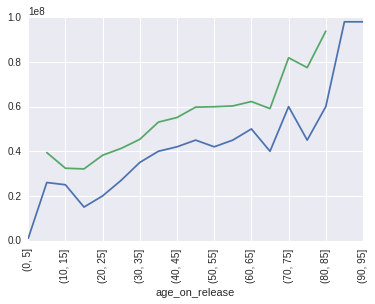

In [116]:
men = actor_data[actor_data.male_txt == 1].copy()
women = actor_data[actor_data.male_txt == 0].copy()

# Set to 5 for 5-year age bins
age_res = 5

for df in [men, women]:
    df.age_on_release = df.age_on_release.astype(int)
    df.age_on_release = pd.cut(x=df.age_on_release, bins=range(0,100,age_res))

def plot_overall_age_curve(df, how):
    if how == 'median':
        return df.groupby('age_on_release').median().production_budget.plot(rot=90)
    if how == 'mean':
        return df.groupby('age_on_release').mean().production_budget.plot(rot=90)
    
plot_overall_age_curve(men, 'median')
plot_overall_age_curve(men, 'mean')

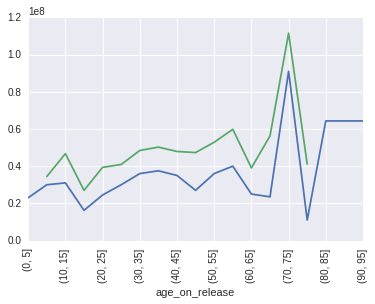

In [117]:
plot_overall_age_curve(women, 'median')
plot_overall_age_curve(women, 'mean')

Compare median of women and men

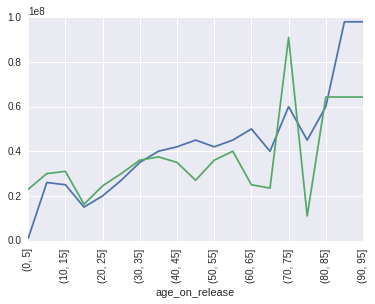

In [118]:
plot_overall_age_curve(men, 'median')
plot_overall_age_curve(women, 'median')

# Simple scatterplot: "ROI" vs age_on_release

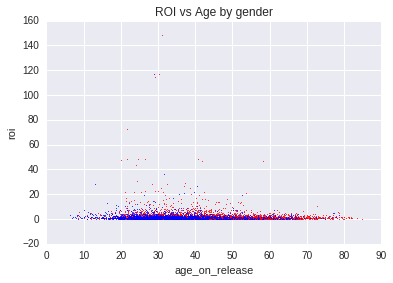

In [119]:
# reset vars
men = actor_data[actor_data.male_txt == 1].copy()
women = actor_data[actor_data.male_txt == 0].copy()

roi_age_title = 'ROI vs Age by gender'
fig, ax = plt.subplots()

for color, df in zip(('r','b'), (men, women)):
    df.plot.scatter('age_on_release','roi', title=roi_age_title, s=1, ax=ax, color=color, lw=0)
    
# if we look at all ROIs, the outlier make the graph illegible!

In [120]:
# ROI threshold to drop outliers!
roi_threshold = 10

men in red, women in blue


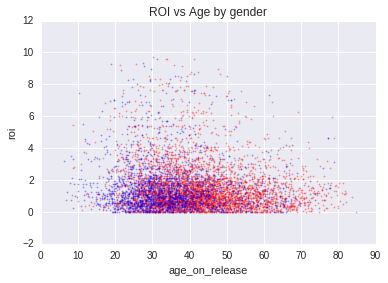

In [121]:
print 'men in red, women in blue'
fig, ax = plt.subplots()

for color, df in zip(('r','b'), (men, women)):
    df[df.roi < roi_threshold].plot.scatter('age_on_release','roi', title=roi_age_title, s=3, ax=ax, color=color, alpha=0.4, lw=0)

# Try the full-feature linear model with thresholded ROIs

In [122]:
actor_data_thresh = actor_data[actor_data.roi < roi_threshold]

In [123]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    actor_data_thresh.drop(
        ['production_budget','actor','domestic_gross','adjusted_gross','worldwide_gross','roi'], axis=1), 
    actor_data_thresh[dependent_var],
    test_size=0.3, 
    random_state=0)

lasso_model = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=5000)
lasso_model.fit(X_train, y_train)

coef_df_eng = make_coef_df(lasso_model, X_train, y_train, significance_thresh=0)
coef_df_eng.head(20)

alpha (aka lambda) for model: 0.000671
intercept for model: 59.324234
R-squared (unadjusted??) of model on training set: 0.0465963183612

got 22 significant columns (abs is > 0.000000) out of 344


,coef,col_name
253,0.554966,1988 births
271,0.384081,American women comedians
263,0.249243,Use mdy dates from February 2016
191,0.208069,African-American actresses
23,0.105629,Pages which use embedded infobox templates wit...
205,-0.095368,1968 births
131,0.080221,1985 births
174,0.055352,American male comedians
297,0.053781,American television writers
289,-0.051633,English male film actors


# The simple model on the roi-thresholded data

In [124]:
print 'dependent_var is:%s\n' % dependent_var

X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data_thresh[['bday','age_on_release','male_txt']], 
    actor_data_thresh[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

dependent_var is:roi

alpha (aka lambda) for model: 0.000002
intercept for model: 69.070929
R-squared (unadjusted??) of model on training set: 0.0322849356221

got 3 significant columns (abs is > 0.000000) out of 3


,coef,col_name
2,-0.075966,male_txt
1,-0.039827,age_on_release
0,-0.033554,bday


In [125]:
print 'dependent_var is:%s\n' % dependent_var

X_train2, X_test2, y_train2, y_test2 = cross_validation.train_test_split(
    actor_data_thresh[['age_on_release','male_txt']], 
    actor_data_thresh[dependent_var], 
    test_size=0.3, 
    random_state=0)

lasso_model2 = linear_model.LassoCV(n_jobs=2, normalize=True)
lasso_model2.fit(X_train2, y_train2)

coef_df2 = make_coef_df(lasso_model2, X_train2, y_train2, significance_thresh=0)
coef_df2.head(20)

dependent_var is:roi

alpha (aka lambda) for model: 0.000161
intercept for model: 1.924890
R-squared (unadjusted??) of model on training set: 0.00891932059291

got 1 significant columns (abs is > 0.000000) out of 2


,coef,col_name
0,-0.010171,age_on_release


# Lasso with polynomials of rank 1, 2, or 3 on:

* age_on_release
* release
* male_txt

Note that birthday year should capture the same info as movie release year (eg decade trends), as long as you have `age_on_release`

In [170]:
def run_poly_lasso(degree, beta_thresh=0.000000000001):
    poly_features = ['age_on_release','release','male_txt']

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        actor_data[poly_features], 
        actor_data[dependent_var], 
        test_size=0.3, 
        random_state=0)

    poly_lasso = make_pipeline(PolynomialFeatures(degree=degree), 
        linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=8000))

    poly_lasso.fit(X_train, y_train)

    lasso = poly_lasso.get_params()['lassocv']
    poly_feat = poly_lasso.get_params()['polynomialfeatures']

    print 'DEGREE: %i' % degree
    print 'Intercept: %f' % lasso.intercept_
    print 'Train score R-squared: %f' % poly_lasso.score(X_train, y_train)

    poly_labels = get_poly_labels(poly_features, poly_feat)
    
    report_df = pd.DataFrame(
        zip(poly_labels, list(lasso.coef_)), columns=['feature','coef'])
    
    # sort by abs val of betas
    report_df = report_df.reindex(report_df.coef.abs().sort_values(ascending=False).index)
    # filter out betas with abs vals below thresh
    pre_filtered_len = len(report_df)
    report_df = report_df[report_df.coef.abs() >= beta_thresh]
    print '\n\nFiltered out %i betas: abs(B)<%f.\n%i remain.' % (
        pre_filtered_len-len(report_df), beta_thresh, len(report_df))
    
    return report_df

In [175]:
run_poly_lasso(degree=3)

DEGREE: 3
Intercept: 4799.574779
Train score R-squared: 0.053789


Filtered out 0 betas: abs(B)<0.000000.
20 remain.


,feature,coef
2,release_p1,-3.770133e+00
1,age_on_release_p1,-8.164136e-01
3,male_txt_p1,6.263093e-01
9,male_txt_p2,1.849483e-02
15,age_on_release_p1_x_male_txt_p2,-1.555799e-02
4,age_on_release_p2,-1.221162e-03
7,release_p2,2.426491e-04
5,age_on_release_p1_x_release_p1,1.492503e-04
10,age_on_release_p3,1.086094e-05
16,release_p3,2.215196e-07


In [172]:
run_poly_lasso(degree=2)

DEGREE: 2
Intercept: 1472.641732
Train score R-squared: 0.041508


Filtered out 4 betas: abs(B)<0.000000.
6 remain.


,feature,coef
2,release_p1,-1.356822
9,male_txt_p2,0.742652
1,age_on_release_p1,-0.025495
6,age_on_release_p1_x_male_txt_p1,-0.017928
7,release_p2,0.000311
4,age_on_release_p2,0.000294


In [173]:
run_poly_lasso(degree=1)

DEGREE: 1
Intercept: 222.748915
Train score R-squared: 0.038166


Filtered out 2 betas: abs(B)<0.000000.
2 remain.


,feature,coef
2,release_p1,-0.110045
1,age_on_release_p1,-0.009379


In [174]:
run_poly_lasso(degree=4)

DEGREE: 4
Intercept: 7979.497493
Train score R-squared: 0.066313


Filtered out 21 betas: abs(B)<0.000000.
14 remain.


,feature,coef
2,release_p1,-5.745332e+00
1,age_on_release_p1,-1.273120e+00
3,male_txt_p1,3.973933e-01
25,age_on_release_p2_x_male_txt_p2,-3.349355e-04
5,age_on_release_p1_x_release_p1,1.909908e-04
7,release_p2,1.595953e-04
4,age_on_release_p2,-1.354231e-04
22,age_on_release_p3_x_male_txt_p1,2.465625e-06
16,release_p3,2.017909e-07
13,age_on_release_p1_x_release_p2,1.425225e-07


# Try model specification with dmatrices

In [241]:
import patsy

y, X = patsy.dmatrices('roi ~ (age_on_release + release + pow(age_on_release,2) + pow(release,2)) * male_txt', 
    data=actor_data , return_type='dataframe')

for col in X.columns:
    print col

Intercept
age_on_release
release
pow(age_on_release, 2)
pow(release, 2)
male_txt
age_on_release:male_txt
release:male_txt
pow(age_on_release, 2):male_txt
pow(release, 2):male_txt


In [261]:
def run_lasso(X, y):
    """
    Convenience wrapper to make a lasso. Use like:
    >>> my_lasso, X_train, X_test, y_train, y_test = run_lasso(X, y)
    
    Then to see the coefficients do:
    >> make_coef_df(my_lasso, X_train, y_train, significance_thresh=0)
    """

    # note that I do y.values.ravel() to avoid a weird sklearn error which I don't understand...
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y.values.ravel(), 
        test_size=0.3, random_state=0)

    lasso = linear_model.LassoCV(n_jobs=2, normalize=True, max_iter=5000)

    lasso.fit(X_train, y_train)

    print 'Intercept: %f' % lasso.intercept_
    print 'Train score R-squared: %f' % lasso.score(X_train, y_train)
        
    return lasso, X_train, X_test, y_train, y_test

In [262]:
patsy_poly_lasso, X_train, X_test, y_train, y_test = run_lasso(X, y)

Intercept: 1014.785787
Train score R-squared: 0.040591


In [263]:
make_coef_df(patsy_poly_lasso, X_train, y_train, significance_thresh=-1)

alpha (aka lambda) for model: 0.000012
intercept for model: 1014.785787
R-squared (unadjusted??) of model on training set: 0.0405905054627

got 10 significant columns (abs is > -1.000000) out of 10


,coef,col_name
2,-0.899064,release
5,0.614230,male_txt
6,-0.024313,age_on_release:male_txt
1,-0.021294,age_on_release
3,0.000242,"pow(age_on_release, 2)"
4,0.000197,"pow(release, 2)"
7,0.000125,release:male_txt
8,0.000076,"pow(age_on_release, 2):male_txt"
9,0.000000,"pow(release, 2):male_txt"
0,0.000000,Intercept


## Now use these features in a plain old OLS model

Get rid of everything but the most significant columns in the lasso results.

In [267]:
import statsmodels.api as sm

# Do train-test split
train_data, test_data = cross_validation.train_test_split(actor_data, test_size = 0.33)

# Generate train with patsy.dmatrices
y_train, X_train = patsy.dmatrices('roi ~ age_on_release*male_txt + release', 
    data=train_data , return_type='dataframe')

ols_model = sm.OLS(y_train, X_train)
res = ols_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    roi   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     56.53
Date:                Wed, 20 Apr 2016   Prob (F-statistic):           1.13e-46
Time:                        19:21:16   Log-Likelihood:                -13232.
No. Observations:                4818   AIC:                         2.647e+04
Df Residuals:                    4813   BIC:                         2.651e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 207.2596     15.477     13.391      0.000       176.917   237.602
age_on_release              0.0029      0.008      0.346      0.730        -0.014     0.019
male_txt                    0.9970      0.383      2.606      0.009         0.247     1.747
age_on_release:male_txt    -0.0204      0.010     -2.075      0.038        -0.040    -0.001
release                    -0.1026      0.008    -13.258      0.000        -0.118    -0.087
==============================================================================
Omnibus:                     9468.569   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         28352282.869
Skew:                          15.480   Prob(JB):                         0.00
Kurtosis:                     377.531   Cond. No.                     5.71e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.71e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""